In [2]:
%matplotlib inline
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
from scipy import fft

In [4]:
filenames = ['data/189_2014.txt']

raw_data = []
for f in filenames:
    raw_data = np.concatenate((raw_data, np.loadtxt(f, delimiter=',', skiprows=1, dtype=str)))
date_data = np.genfromtxt((i[:-2] if i[-1] == '3' else '' for i in raw_data), delimiter=';', 
                     dtype=[('date', 'U19'), ('height', 'float')])

In [5]:
file = open("data.txt", "w")
beginning = np.datetime64(to_datetime(date_data[0][0], dayfirst=True), 's')
for d in date_data:
    file.writelines([str(np.datetime64(to_datetime(d[0], dayfirst=True), 's'))+';', 
                     str((np.datetime64(to_datetime(d[0], dayfirst=True), 's')
                          -beginning).item().total_seconds())+';', str(d[1])+'\n'])
file.close()

## import

In [4]:
data = np.genfromtxt('data.txt', delimiter=";", usecols = range(1,3))
dates = np.genfromtxt('data.txt', dtype='datetime64[s]', delimiter=";", usecols = range(0,1))

## fix data

In [5]:
fixed_data = np.copy(data)

In [6]:
fixed_data = np.copy(data)
for i, index in enumerate(np.nditer(np.where(data[1:,0]-data[:-1,0] != 600))):
    fixed_data = np.insert(fixed_data, index + i + 1, [data[index, 0] + 600, data[index, 1] + (data[index + 1, 1]-data[index, 1])/2], axis=0)

<IPython.core.display.Javascript object>


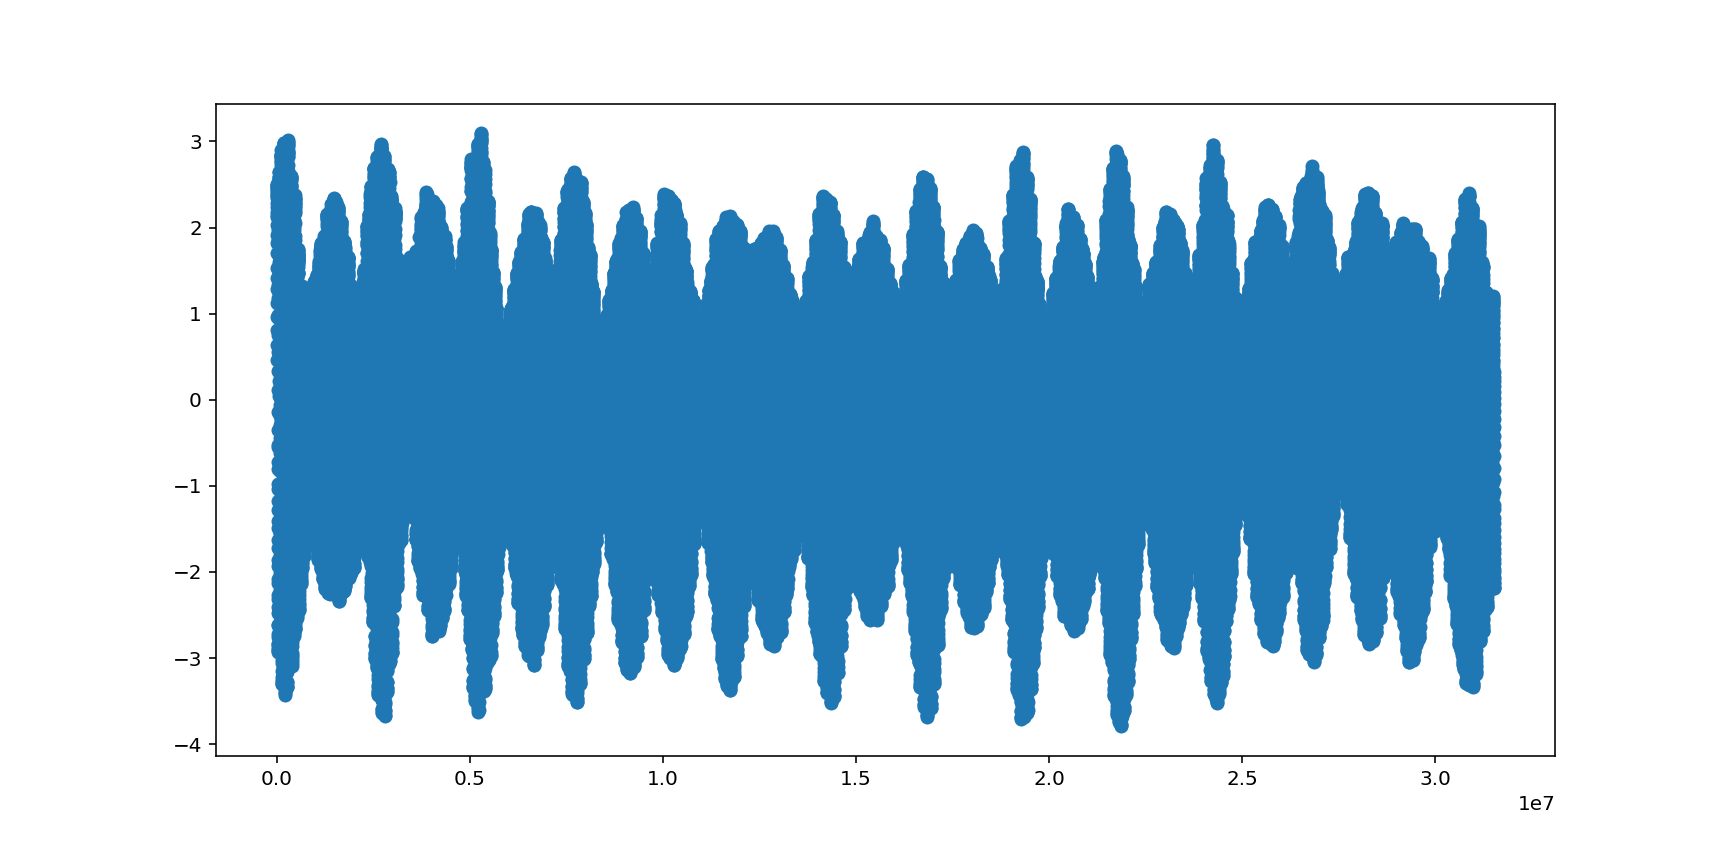

In [7]:
plt.rcParams["figure.figsize"] = (12,6)
period = (6*60 + 12) * 60
offset = 12000
mean_height = np.mean(fixed_data[:,1])

n = len(data)

x = fixed_data[:n, 0]
y = fixed_data[:n, 1] - mean_height

T = 600

fig, ax = plt.subplots()
ax.scatter(x, y)

<IPython.core.display.Javascript object>


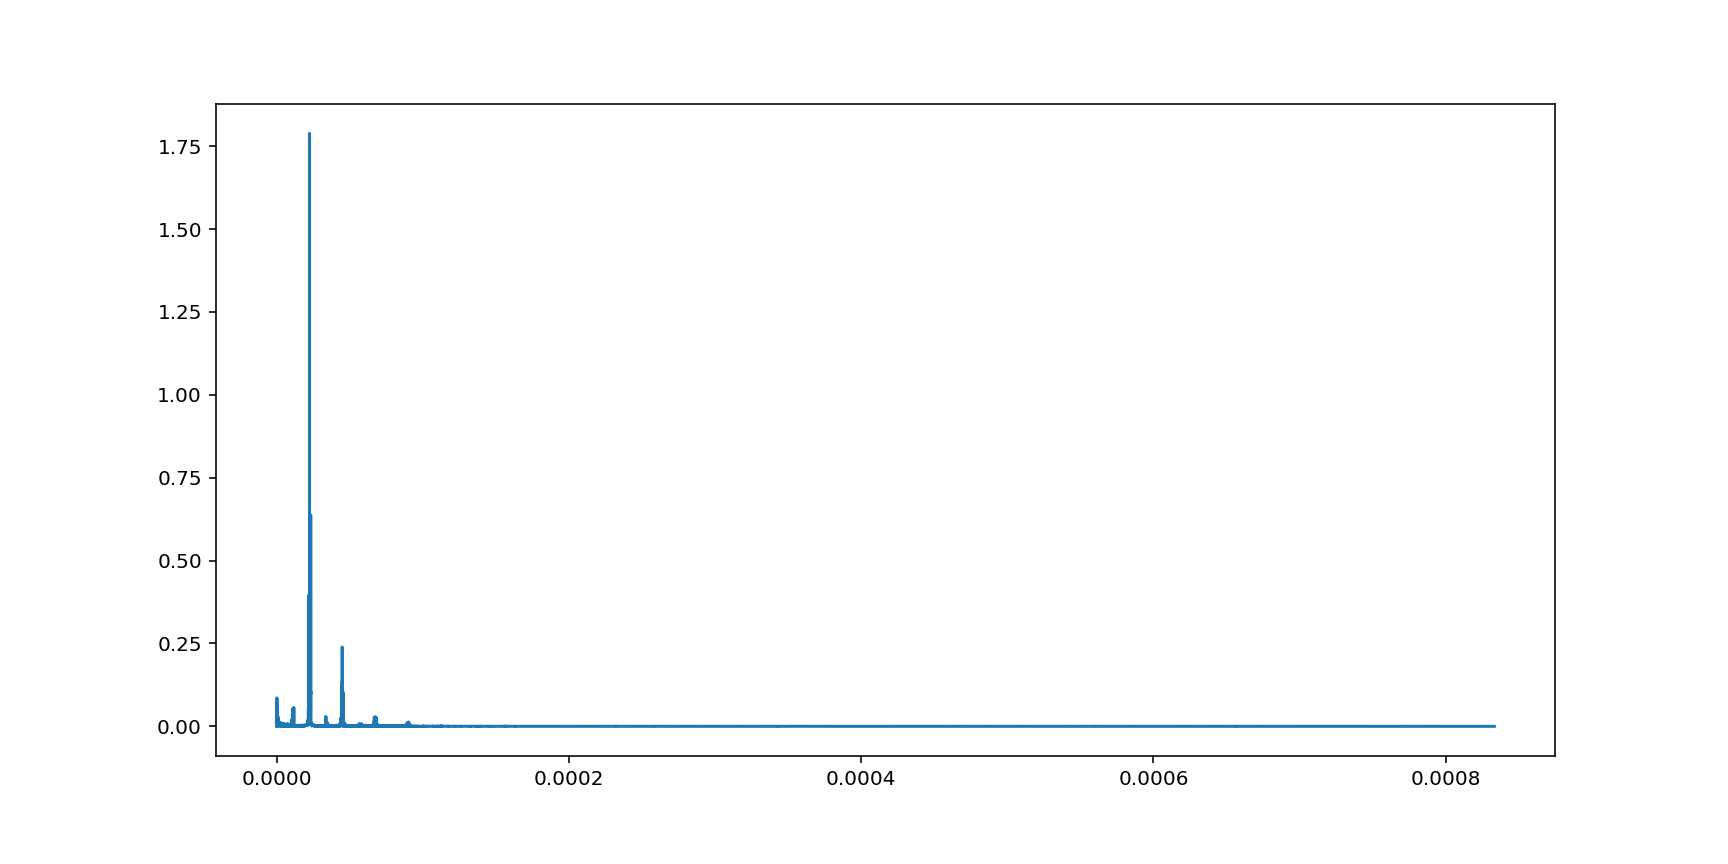

In [8]:
yf = fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), n//2)
Ck = 2/n * yf
aC = abs(Ck)

fig, ax = plt.subplots()
ax.plot(xf, aC[:n//2])

In [14]:
a = 0.05
osz =  np.column_stack((xf[1:][aC[1:n//2] > a], aC[1:n//2][aC[1:n//2] > a]))
osz = osz[(-osz[:,1]).argsort()]
omega = 2*np.pi*osz[:,0]
print(len(osz))
for i, o in enumerate(osz):
    print(i, '{} h, {} d'.format(1/o[0]/3600, 1/o[0]/3600/24))

29
0 12.422695035460992 h, 0.517612293144208 d
1 11.9972602739726 h, 0.49988584474885833 d
2 12.656069364161848 h, 0.5273362235067437 d
3 12.405099150141641 h, 0.5168791312559017 d
4 6.211347517730496 h, 0.258806146572104 d
5 12.440340909090907 h, 0.5183475378787877 d
6 12.387553041018386 h, 0.516148043375766 d
7 6.269148174659985 h, 0.26121450727749934 d
8 12.458036984352772 h, 0.5190848743480322 d
9 11.964480874316939 h, 0.49852003642987247 d
10 6.103135888501741 h, 0.25429732868757254 d
11 6.206945428773919 h, 0.2586227261989133 d
12 11.980848153214774 h, 0.4992020063839489 d
13 12.37005649717514 h, 0.5154190207156308 d
14 8757.999999999998 h, 364.9166666666666 d
15 12.475783475783475 h, 0.5198243114909781 d
16 12.619596541786743 h, 0.5258165225744477 d
17 12.493580599144078 h, 0.5205658582976699 d
18 2189.4999999999995 h, 91.22916666666664 d
19 12.352609308885754 h, 0.5146920545369064 d
20 12.013717421124825 h, 0.5005715592135344 d
21 23.928961748633878 h, 0.9970400728597449 d
22 1

<IPython.core.display.Javascript object>


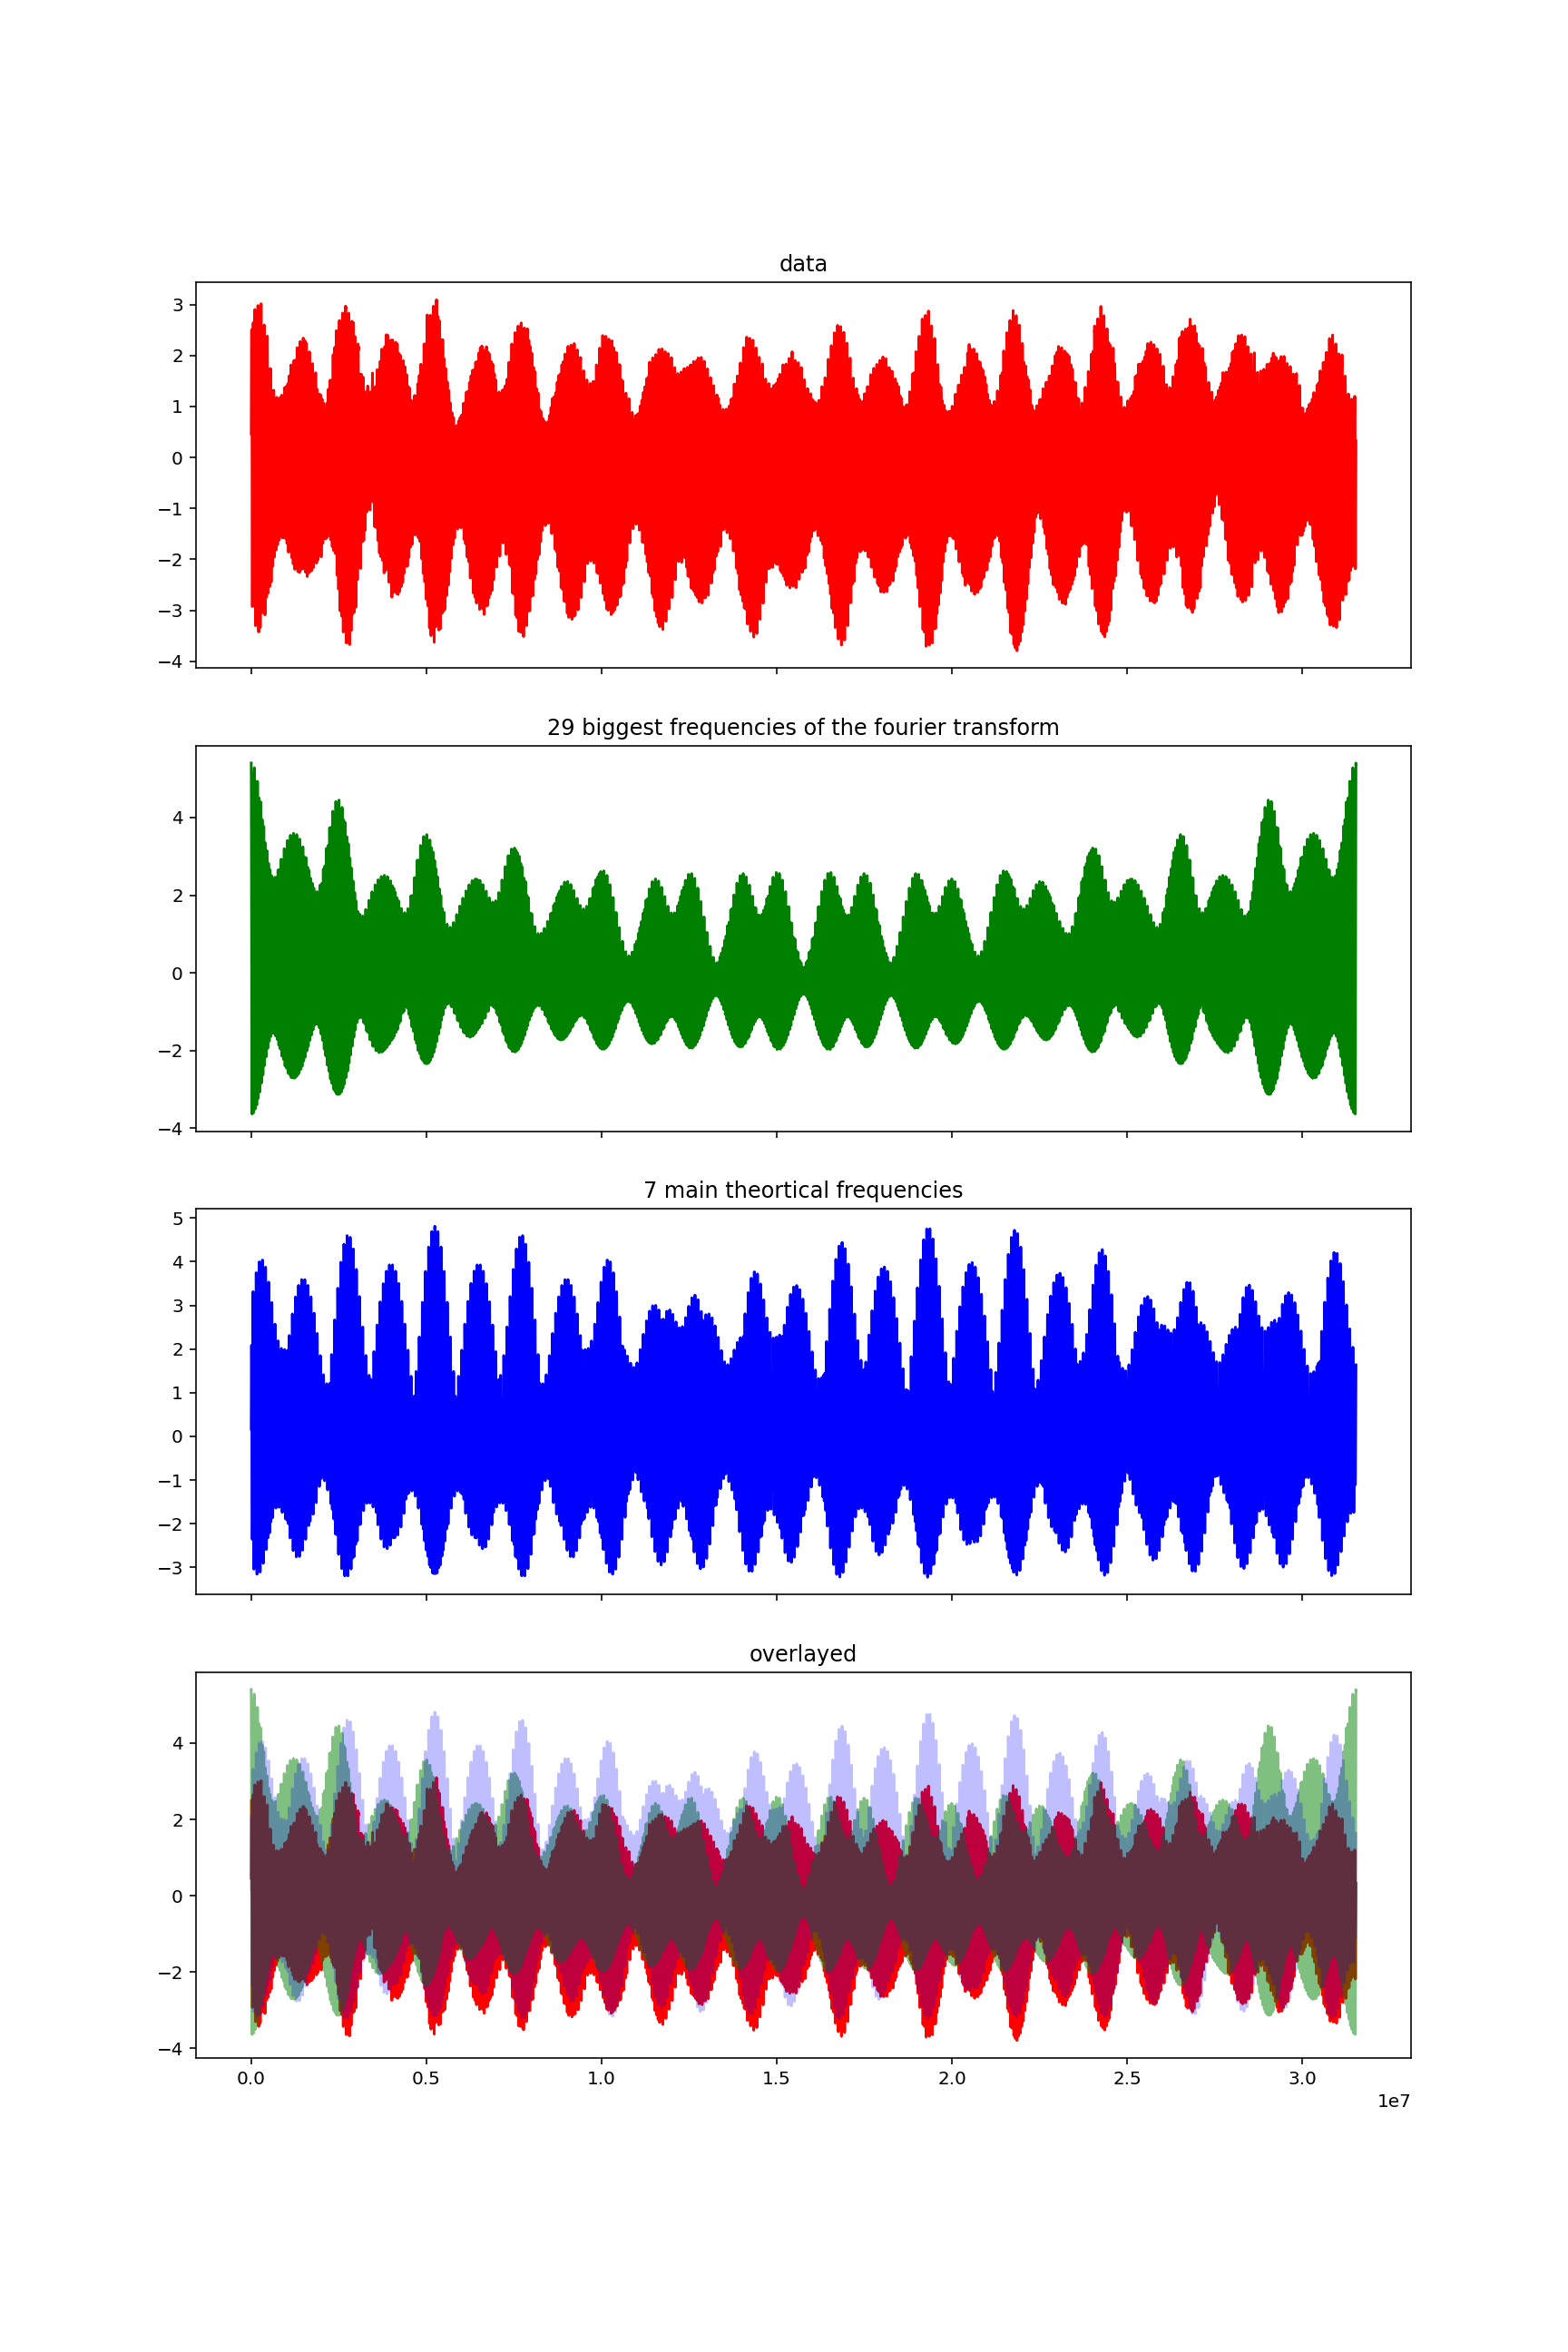

Text(0.5, 1.0, 'overlayed')

In [20]:
plt.rcParams["figure.figsize"] = (12,18)
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title('data')
ax[0].plot(x, y, color='r')
ax[3].plot(x, y, zorder=0, color='r')
lin_x = np.linspace(0, x[-1], int(1E6))

# meins
func = np.zeros_like(lin_x)
for i in range(len(osz)):
    func += osz[i, 1]*np.cos(omega[i]*lin_x)

ax[1].plot(lin_x, func, color='g')
ax[3].plot(lin_x, func, zorder=1, color='g', alpha=0.5)
ax[1].set_title('29 biggest frequencies of the fourier transform')

# nach https://tidesandcurrents.noaa.gov/publications/Understanding_Tides_by_Steacy_finalFINAL11_30.pdf
start = 0.524E7
ax[2].set_title('7 main theortical frequencies')
func = np.zeros_like(lin_x)
for o in [(1, 12.42), (0.46, 12.00), (0.41, 25.82), (0.40, 23.93), (0.20, 12.66), (0.19, 24.07), (0.03, 12.19)]:
    func += 1.78854454*o[0]*np.cos(2*np.pi/(o[1]*3600)*(lin_x-start))

ax[2].plot(lin_x, func, zorder=1, color='b')
ax[3].plot(lin_x, func, zorder=2, color='b', alpha=0.25)
ax[3].set_title('overlayed')

In [83]:
# Vegleich: https://en.wikipedia.org/wiki/Theory_of_tides#Tidal_constituents

in_h = 1/osz[:,0]/3600
print('Periods constituents\t\t\t\ttheoretical time\ttime in fourier frequencies\n')
print('M_2 Principal Lunar semidiurnal:\t\t{} h\t\t\t{:.3f} h'.format(12.42, in_h[0]))
print('S_2 Principal Solar semidiurnal:\t\t{} h\t\t\t{:.3f} h'.format(12.00, in_h[1]))
print('O_1 Principal Lunar Declinational diurnal:\t{} h\t\t\t{:.3f} h'.format(25.82, in_h[26]))
print('K_1 Luni-solar Declinational diurnal:\t\t{} h\t\t\t{:.3f} h'.format(23.93, in_h[21]))
print('N_2 Larger Lunar Elliptic semidiurnal:\t\t{} h\t\t\t{:.3f} h'.format(12.66, in_h[2]))
print('P_1 Principal Solar Declinational diurnal:\t{} h\t\t\t{}'.format(24.07, '--'))
print('L_2 Smaller Lunar Elliptic semidiurnal:\t\t{} h\t\t\t{}\n'.format(12.19, '--'))

print('M_2: rotation of the Earth relativ to the Moon')
print('S_2: rotation of the Earth relativ to the Sun')
print('N_2/L_2: elliptic orbit of the Moon')
print('O_1/K_1: declination orbital plane of the Moon relative to the rotational plane of the earth, because the tides are stronger at the equator, the high and low tides at night have a different amplitude than the high and low tides at daytime')
print('P_1/K_1: declination orbital plane of the Sun relative to the rotational plane of the earth')

Periods constituents				theoretical time	time in fourier frequencies

M_2 Principal Lunar semidiurnal:		12.42 h			12.423 h
S_2 Principal Solar semidiurnal:		12.0 h			11.997 h
O_1 Principal Lunar Declinational diurnal:	25.82 h			25.835 h
K_1 Luni-solar Declinational diurnal:		23.93 h			23.929 h
N_2 Larger Lunar Elliptic semidiurnal:		12.66 h			12.656 h
P_1 Principal Solar Declinational diurnal:	24.07 h			--
L_2 Smaller Lunar Elliptic semidiurnal:		12.19 h			--

M_2: rotation of the Earth relativ to the Moon
S_2: rotation of the Earth relativ to the Sun
N_2/L_2: elliptic orbit of the Moon
O_1/K_1: declination orbital plane of the Moon relative to the rotational plane of the earth, because the tides are stronger at the equator, the high and low tides at night have a different amplitude than the high and low tides at daytime
P_1/K_1: declination orbital plane of the Sun relative to the rotational plane of the earth


## Fourier is fun